# TODO:
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy - ADAM -TODO
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias) - TODO (zmienaimy seed i patrzymy czy tunowalność się zmienia -> tabelka z 10 seedami i patrzyma jak zmienia się tunowalnosć) -TODO ( przy pisaniu raportu)

### Imports

In [1]:
import itertools
import os
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Integer, Real

from utills.best_config_bayes import (
    find_best_config_using_bayes,
    find_best_configs_in_search_space_with_bayes,
)
from utills.best_config_random_search import (
    find_best_configs_in_search_space_with_random_search,
)
from utills.dataset import load_dataset_from_id, split_dataset
from utills.dump_data import (
    dump_optimal_config_search_history,
    dump_scores_to_csv,
    dump_tunability_to_csv,
)
from utills.optimal_config import find_optimal_configuration_for_all_datasets
from utills.pipeline import get_column_transformer
from utills.tunability import (
    calculate_aggregate_tunability,
    calculate_tunability_on_each_dataset,
)

# Constants

In [2]:
NUM_ITER_BAYES = 50
NUM_POINTS_RS_DECISION_TREE = 50
NUM_POINTS_RS_ELASTIC_NET = 50
NUM_POINTS_RS_RANDOM_FOREST = 50
SEED = 5678
os.makedirs("output_data/plots", exist_ok=True)

### Utill functions

### Load datasets

In [3]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
cars_dataset_id = (
    44994  # https://www.openml.org/search?type=data&status=active&id=44994
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)

rmftsa_ladata_dataset_id = (
    666  # https://www.openml.org/search?type=data&status=active&id=666
)
boston_dataset_id = 531  # https://www.openml.org/search?type=data&status=active&id=531

treasury_dataset_id = (
    42367  # https://www.openml.org/search?type=data&status=active&id=42367
)

bank32nh_dataset_id = (
    558  # https://www.openml.org/search?type=data&status=active&id=558
)

puma32H_dataset_id = 308  # https://www.openml.org/search?type=data&status=active&id=308

fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

cars_dataset: DataFrame = load_dataset_from_id(id=cars_dataset_id)
cars_regression_class = "Price"

diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

rmftsa_ladata_dataset = load_dataset_from_id(id=rmftsa_ladata_dataset_id)
rmftsa_ladata_regression_class = "Respiratory_Mortality"

boston_dataset = load_dataset_from_id(id=boston_dataset_id)
boston_regression_class = "MEDV"

treasury_dataset = load_dataset_from_id(id=treasury_dataset_id)
treasury_regression_class = "1MonthCDRate"

bank32nh_dataset = load_dataset_from_id(id=bank32nh_dataset_id)
bank32nh_regression_class = "rej"

puma32H_dataset = load_dataset_from_id(id=puma32H_dataset_id)
puma32H_regression_class = "thetadd6"

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` 

### Split data into train and test sets

In [4]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_cars,
    X_test_cars,
    y_train_cars,
    y_test_cars,
) = split_dataset(data=cars_dataset, class_=cars_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

(
    X_train_rmftsa_ladata,
    X_test_rmftsa_ladata,
    y_train_rmftsa_ladata,
    y_test_rmftsa_ladata,
) = split_dataset(rmftsa_ladata_dataset, rmftsa_ladata_regression_class)

X_train_boston, X_test_boston, y_train_boston, y_test_boston = split_dataset(
    boston_dataset, boston_regression_class
)

X_train_treasury, X_test_treasury, y_train_treasury, y_test_treasury = split_dataset(
    treasury_dataset, treasury_regression_class
)

X_train_bank32nh, X_test_bank32nh, y_train_bank32nh, y_test_bank32nh = split_dataset(
    bank32nh_dataset, bank32nh_regression_class
)

X_train_puma32H, X_test_puma32H, y_train_puma32H, y_test_puma32H = split_dataset(
    puma32H_dataset, puma32H_regression_class
)

In [5]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_cars, y_train_cars),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
        (X_train_rmftsa_ladata, y_train_rmftsa_ladata),
        (X_train_boston, y_train_boston),
        (X_train_treasury, y_train_treasury),
    ]

In [6]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_cars, y_test_cars),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
        (X_test_rmftsa_ladata, y_test_rmftsa_ladata),
        (X_test_boston, y_test_boston),
        (X_test_treasury, y_test_treasury),
    ]


# 1. Decision Tree

## Prepare model and search space

In [7]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor(random_state=SEED)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [8]:
def get_parameter_grid_decision_tree():
    # parameters space
    random.seed(SEED)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_DECISION_TREE
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

## Find optimal default hyperparameters 

In [9]:
# find teta*

(
    optimal_config_decision_tree,
    best_summary_score_decision_tree,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    get_model=get_decision_tree_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/decision_tree/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


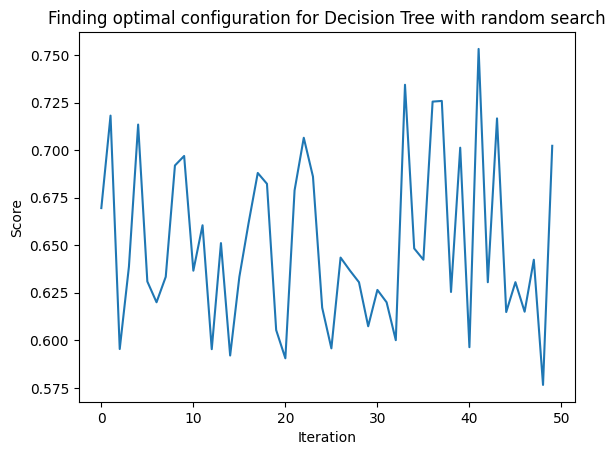

In [10]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Decision Tree with random search")
os.makedirs("output_data/plots", exist_ok=True)
plt.savefig("output_data/plots/optimal_decision_tree.png")
plt.show()

In [11]:
print(optimal_config_decision_tree)
print(best_summary_score_decision_tree)

{'model__ccp_alpha': 0.2, 'model__max_depth': 26, 'model__min_samples_split': 14, 'model__min_samples_leaf': 4}
0.7531784349563134


## Evaluate model with optimal hyperparameters on each dataset

In [12]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_decision_tree_pipeline()
    optimal_model.set_params(**optimal_config_decision_tree)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal decision tree score on dataset : " + str(score))

Optimal decision tree score on dataset : 0.9653594357796195
Optimal decision tree score on dataset : 0.9423080799744314
Optimal decision tree score on dataset : 0.2814934770244052
Optimal decision tree score on dataset : 0.6939121852815667
Optimal decision tree score on dataset : 0.5694226766895742
Optimal decision tree score on dataset : 0.8729172486293046
Optimal decision tree score on dataset : 0.9468359413152911


## Find best hyperparameters for given dataset with random search

In [13]:
# find tate^(j)*
(
    best_decision_tree_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    get_pipeline=get_decision_tree_pipeline,
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/decision_tree/random_search_iteration_scores_dataset_{i}.csv",
    )

dataset: 0
score: 0.9653594357796195
best config: {'model__ccp_alpha': 0.2, 'model__max_depth': 26, 'model__min_samples_split': 14, 'model__min_samples_leaf': 4}
dataset: 1
score: 0.9423080799744314
best config: {'model__ccp_alpha': 0.2, 'model__max_depth': 26, 'model__min_samples_split': 14, 'model__min_samples_leaf': 4}
dataset: 2
score: 0.4692111427031108
best config: {'model__ccp_alpha': 0.9, 'model__max_depth': 15, 'model__min_samples_split': 55, 'model__min_samples_leaf': 9}
dataset: 3
score: 0.695542389931806
best config: {'model__ccp_alpha': 0.6000000000000001, 'model__max_depth': 15, 'model__min_samples_split': 17, 'model__min_samples_leaf': 4}
dataset: 4
score: 0.5694226766895744
best config: {'model__ccp_alpha': 0.6000000000000001, 'model__max_depth': 15, 'model__min_samples_split': 17, 'model__min_samples_leaf': 4}
dataset: 5
score: 0.8800942161627985
best config: {'model__ccp_alpha': 0.0, 'model__max_depth': 8, 'model__min_samples_split': 10, 'model__min_samples_leaf': 3}


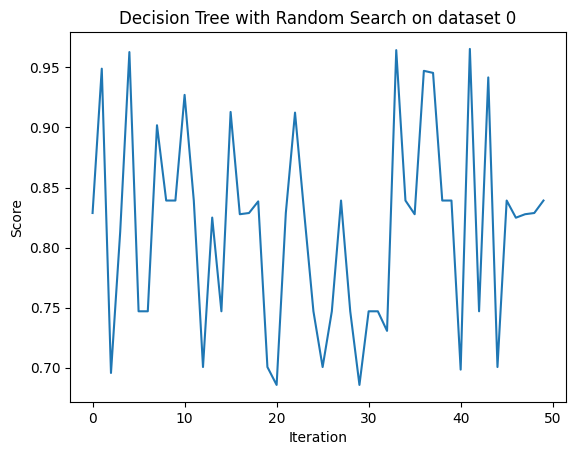

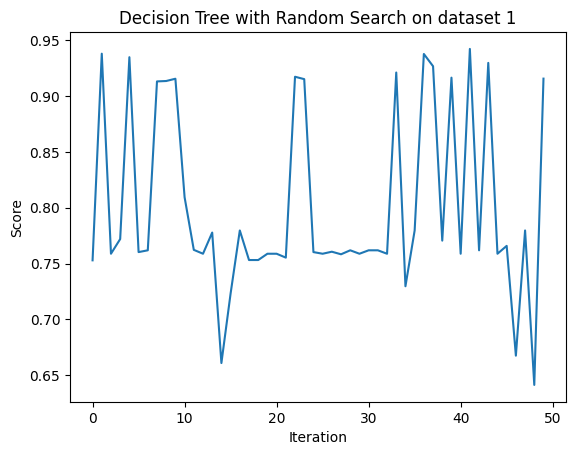

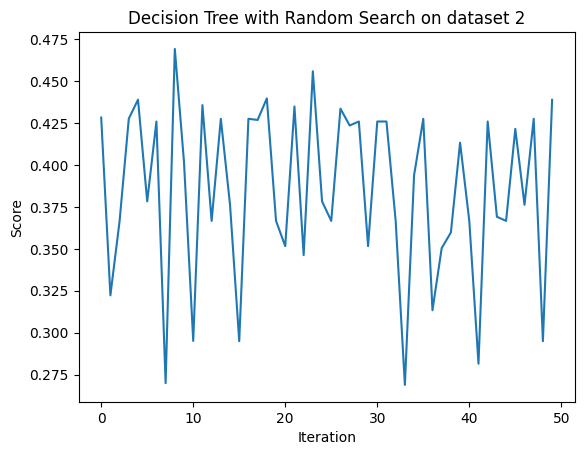

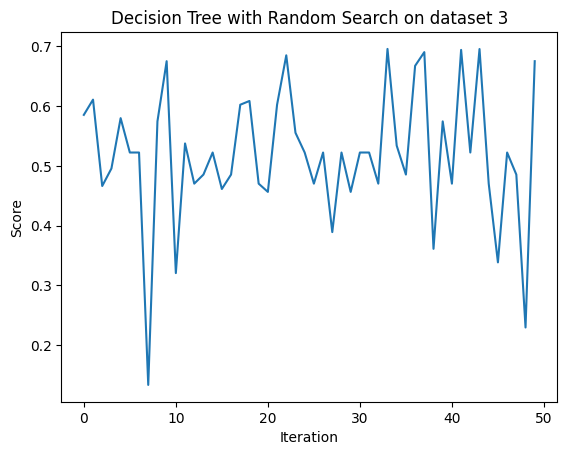

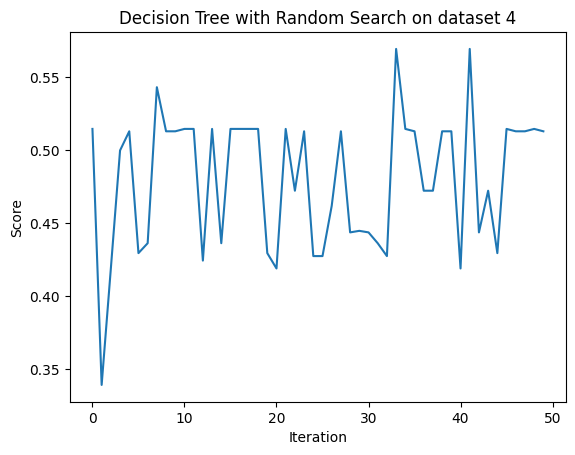

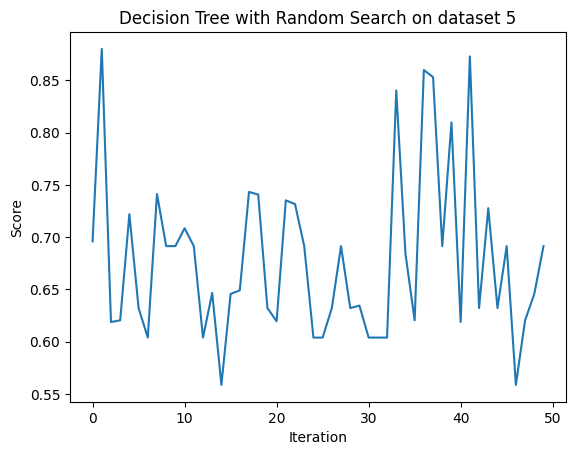

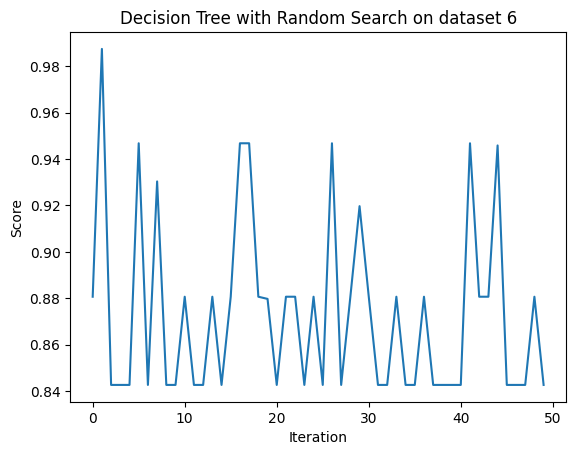

In [14]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Decision Tree with Random Search on dataset {i}")
    plt.savefig(f"output_data/plots/random_search_decision_tree_{i}.png")
    plt.show()

## Calculate tunability on each dataset

In [15]:
# find d^j
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_decision_tree_configs_for_each_dataset,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/random_search_tunability.csv",
)

d^j: 0.9653594357796195 - 0.9653594357796195 = 0.0
d^j: 0.9423080799744314 - 0.9423080799744314 = 0.0
d^j: 0.2814934770244052 - 0.4692111427031108 = -0.18771766567870563
d^j: 0.6939121852815667 - 0.695542389931806 = -0.0016302046502392198
d^j: 0.5694226766895742 - 0.5694226766895744 = -1.1102230246251565e-16
d^j: 0.8729172486293046 - 0.8800942161627985 = -0.007176967533493839
d^j: 0.9468359413152911 - 0.9875320376845944 = -0.04069609636930327


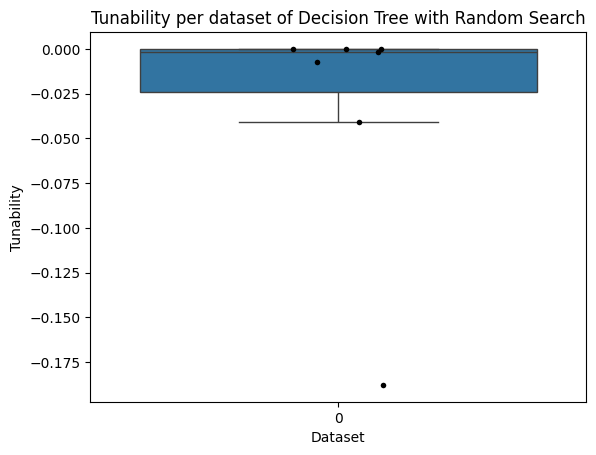

In [16]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of Decision Tree with Random Search")
plt.savefig("output_data/plots/tunability_RS_decision_tree.png")
# show the plot
plt.show()

In [17]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.033888704890248866


## Find best hyperparameters for given dataset with bayesian search

In [18]:
def get_bayes_search_space_decision_tree():
    return (
        {
            "model__ccp_alpha": Real(0.0, 1.0),
            "model__max_depth": Integer(1, 30),
            "model__min_samples_split": Integer(2, 60),
            "model__min_samples_leaf": Integer(1, 60),
        },
        NUM_ITER_BAYES,
    )

In [19]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
(
    best_configs_for_decision_tree,
    histories,
) = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_decision_tree(),
    get_pipeline=get_decision_tree_pipeline,
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/decision_tree/bayes_iteration_scores_dataset_{i}.csv"
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = 0.6223527879616626
Iteration 2: Score = 0.6310443819100943
Iteration 3: Score = 0.7806401218620961
Iteration 4: Score = 0.637415846946202
Iteration 5: Score = 0.7865466239620986
Iteration 6: Score = 0.5817676989662024
Iteration 7: Score = 0.7814191177978664
Iteration 8: Score = -0.05320919309927987
Iteration 9: Score = 0.9131141277869329
Iteration 10: Score = 0.7860359131759462
Iteration 11: Score = 0.7913990245351916
Iteration 12: Score = 0.8774095909186859
Iteration 13: Score = 0.6938644238320535
Iteration 14: Score = 0.8882207327197854
Iteration 15: Score = 0.6938644238320535
Iteration 16: Score = 0.8908135842708627
Iteration 17: Score = 0.9661006462089168
Iteration 18: Score = 0.6223527879616626
Iteration 19: Score = 0.9660862354270773
Iteration 20: Score = 0.7819467475731763
Iteration 21: Score = 0.9306507491878806
Iteration 22: Score = 0.6938644238320535
Iteration 23: Score = 0.9662060791421638
Iteration 24: Score = 0.8603545744348262
Iteration 25: Score = 0.

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = 0.6067338718320407
Iteration 2: Score = 0.7327489049701492
Iteration 3: Score = 0.7573338202582235
Iteration 4: Score = 0.7376894771629809
Iteration 5: Score = 0.8684235269913009
Iteration 6: Score = 0.7464422552709599
Iteration 7: Score = 0.7581198013455449
Iteration 8: Score = 0.7435585326248331
Iteration 9: Score = 0.9140527863089952
Iteration 10: Score = 0.7845320957614942
Iteration 11: Score = 0.9118586515940343
Iteration 12: Score = 0.9235735506079104
Iteration 13: Score = 0.4027899856735796
Iteration 14: Score = 0.9184310205761104
Iteration 15: Score = 0.9080964984101957
Iteration 16: Score = 0.8104132638705857
Iteration 17: Score = 0.9140845628270767
Iteration 18: Score = 0.9090730122131714
Iteration 19: Score = 0.8104132638705857
Iteration 20: Score = 0.9080964984101957
Iteration 21: Score = 0.8619890113996075
Iteration 22: Score = 0.9140845628270767
Iteration 23: Score = 0.9090294100385613
Iteration 24: Score = 0.859424018449617
Iteration 25: Score = 0.86

### Plot bayes optimization history for each dataset

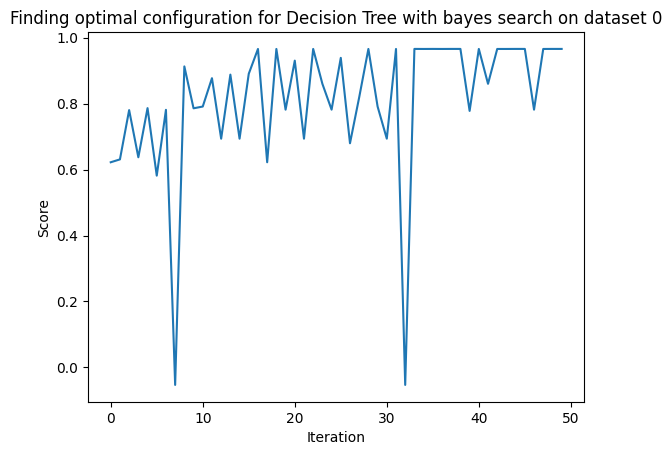

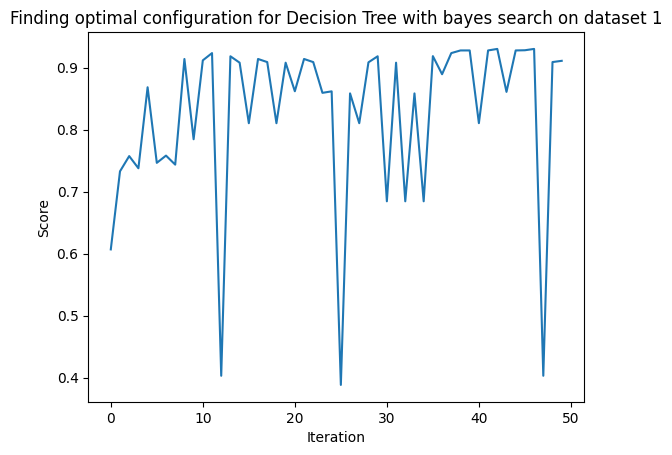

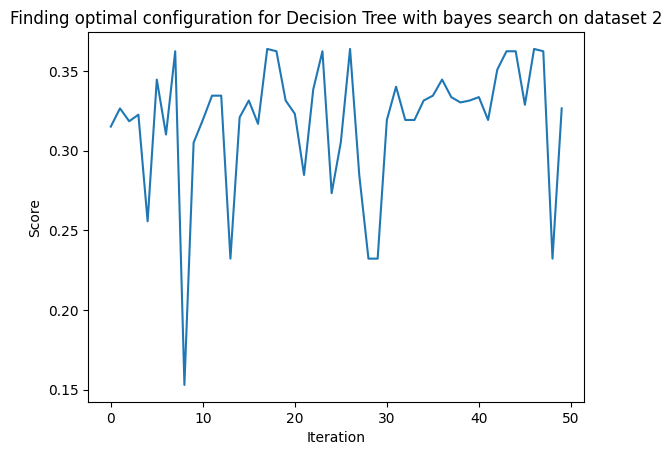

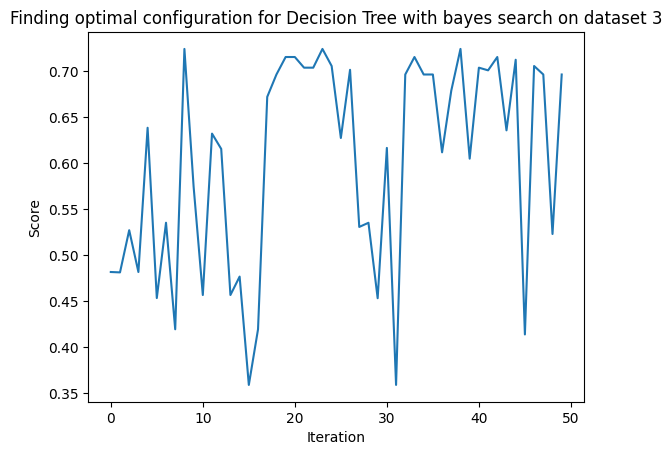

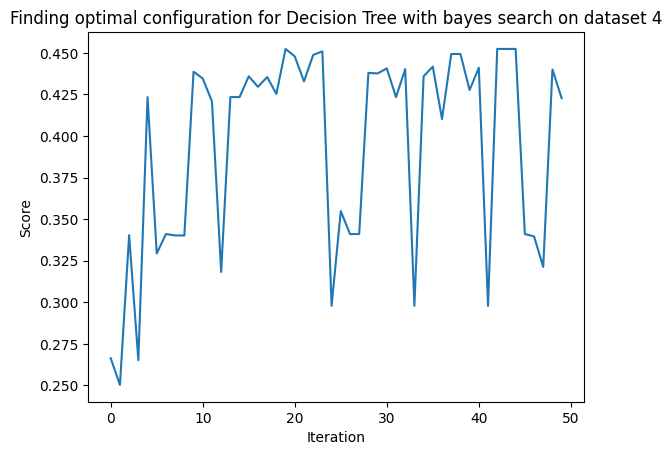

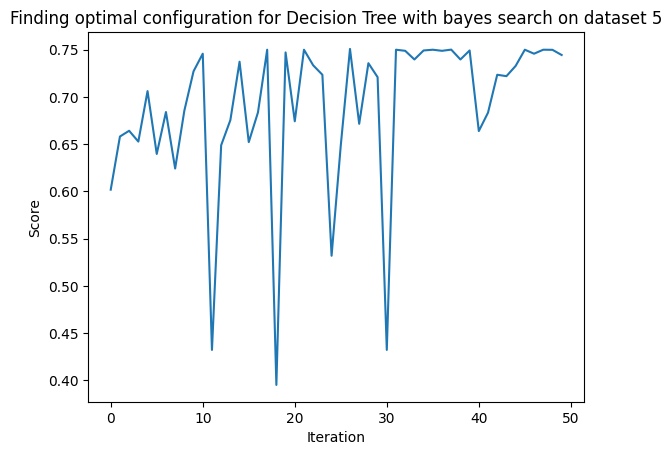

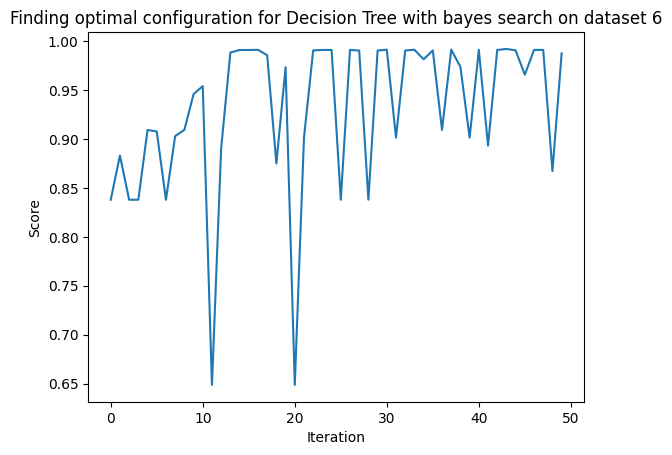

In [20]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for Decision Tree with bayes search on dataset {i}"
    )
    plt.savefig(f"output_data/plots/bayes_decision_tree_{i}.png")
    plt.show()

## Calculate tunability on each dataset

In [21]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_decision_tree,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/bayes_tunability.csv",
)

d^j: 0.9653594357796195 - 0.9547108553540419 = 0.010648580425577592
d^j: 0.9423080799744314 - 0.943001844414337 = -0.000693764439905542
d^j: 0.2814934770244052 - 0.3666575524702239 = -0.08516407544581872
d^j: 0.6939121852815667 - 0.5849221837876848 = 0.10899000149388194
d^j: 0.5694226766895742 - 0.5146097729675971 = 0.05481290372197711
d^j: 0.8729172486293046 - 0.7500343658335947 = 0.12288288279570991
d^j: 0.9468359413152911 - 0.9851595481600934 = -0.038323606844802294


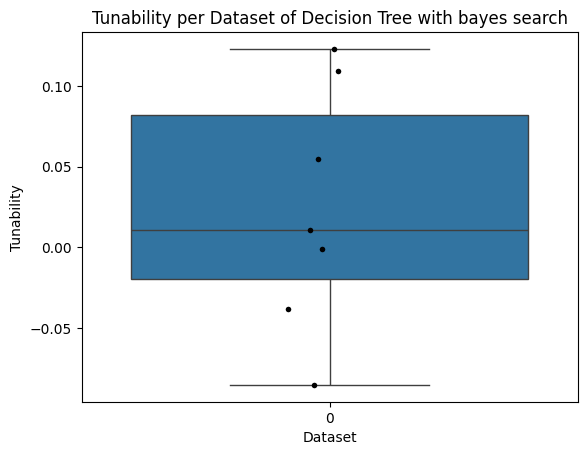

In [22]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Decision Tree with bayes search")
plt.savefig("output_data/plots/tunability_BO_decision_tree.png")
# show the plot
plt.show()

In [23]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.024736131672374286


# 2. ElasticNet

## Prepare model and search space

In [24]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000, random_state=SEED)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [25]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(SEED)
    alpha = [2**i for i in range(-10, 11, 1)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_ELASTIC_NET
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

## Find optimal default hyperparameters 

In [26]:
# find teta*

(
    optimal_config_elasticnet,
    best_summary_score_elasticnet,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    get_model=get_elasticnet_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/elasticnet/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.755e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.963e+10, tolerance: 5.962e+06 Linear reg

7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.035e+09, tolerance: 5.962e+06 Linear reg

26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.421e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.843e+10, tolerance: 5.962e+06 Linear reg

44


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.861e+11, tolerance: 4.005e+09
  model = cd_fast.enet_coordinate_descent(


45
46
47
48
49


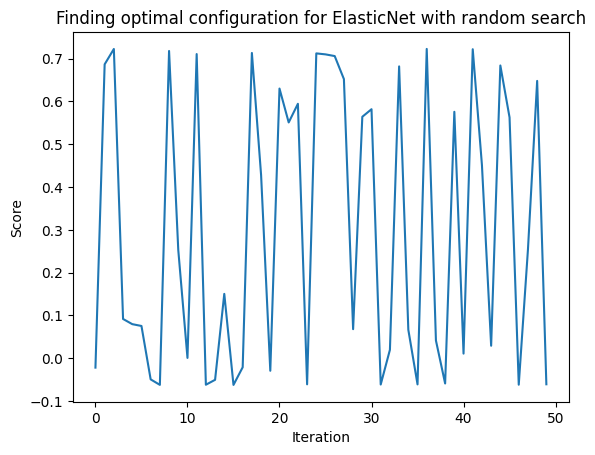

In [27]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for ElasticNet with random search")
plt.savefig("output_data/plots/optimal_elasticnet.png")
plt.show()

In [28]:
print(optimal_config_elasticnet)
print(best_summary_score_elasticnet)

{'model__alpha': 0.001953125, 'model__l1_ratio': 0.6000000000000001}
0.7225858254606576


## Evaluate model with optimal hyperparameters on each dataset

In [29]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_elasticnet_pipeline()
    optimal_model.set_params(**optimal_config_elasticnet)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal elasticnet score on dataset : " + str(score))

Optimal elasticnet score on dataset : 0.9497549084200523
Optimal elasticnet score on dataset : 0.9233088215231575
Optimal elasticnet score on dataset : 0.45658166685444057
Optimal elasticnet score on dataset : 0.543178121379066
Optimal elasticnet score on dataset : 0.556445284954607
Optimal elasticnet score on dataset : 0.6371515614536902
Optimal elasticnet score on dataset : 0.9916804136395898


## Find best hyperparameters for given dataset with random search

In [30]:
# find tate^(j)*
(
    best_elasticnet_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    get_pipeline=get_elasticnet_pipeline,
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/elasticnet/random_search_iteration_scores_dataset_{i}.csv",
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.755e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e+06, tolerance: 1.561e+03 Linear reg

dataset: 0
score: 0.9497549084200523
best config: {'model__alpha': 0.001953125, 'model__l1_ratio': 0.6000000000000001}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.963e+10, tolerance: 5.962e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.035e+09, tolerance: 5.962e+06 Linear reg

dataset: 1
score: 0.923922092472427
best config: {'model__alpha': 0.125, 'model__l1_ratio': 1.0}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e+06, tolerance: 2.145e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.668e+05, tolerance: 2.145e+02 Linear reg

dataset: 2
score: 0.4647832830745732
best config: {'model__alpha': 0.125, 'model__l1_ratio': 0.9500000000000001}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e+13, tolerance: 4.005e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.440e+12, tolerance: 4.005e+09 Linear reg

dataset: 3
score: 0.5486076640143884
best config: {'model__alpha': 0.0625, 'model__l1_ratio': 0.9500000000000001}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e+03, tolerance: 3.145e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.798e+02, tolerance: 3.145e-01 Linear reg

dataset: 4
score: 0.5606357787721593
best config: {'model__alpha': 0.0009765625, 'model__l1_ratio': 0.4}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+04, tolerance: 3.510e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.239e+03, tolerance: 3.510e+00 Linear reg

dataset: 5
score: 0.6562711803182308
best config: {'model__alpha': 0.0078125, 'model__l1_ratio': 0.0}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.679e+03, tolerance: 9.548e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.172e+02, tolerance: 9.548e-01 Linear reg

dataset: 6
score: 0.9921425833911399
best config: {'model__alpha': 0.0009765625, 'model__l1_ratio': 0.4}


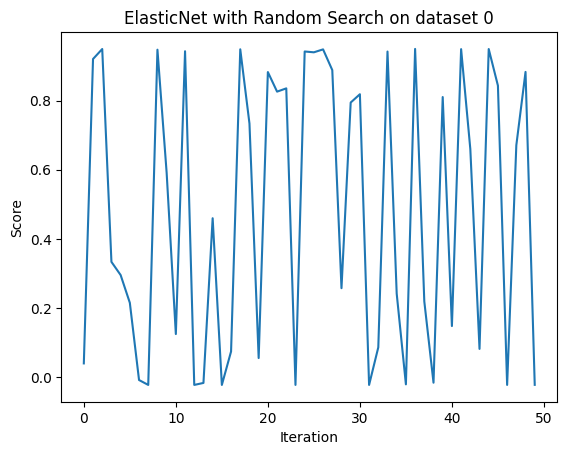

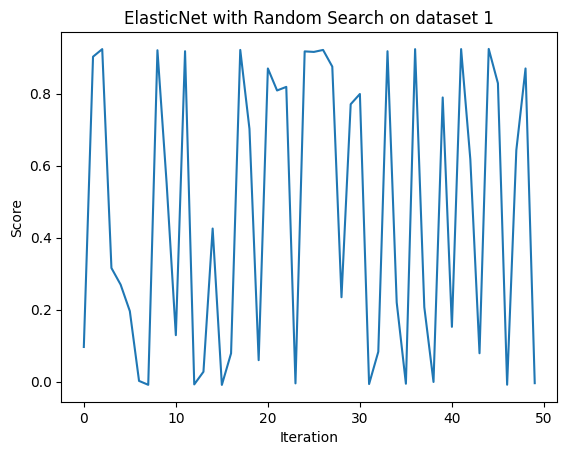

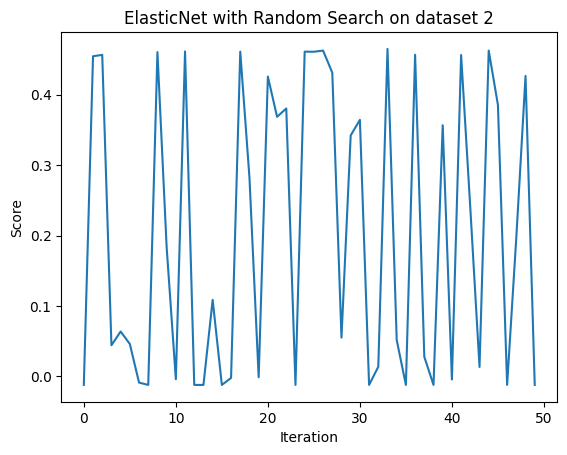

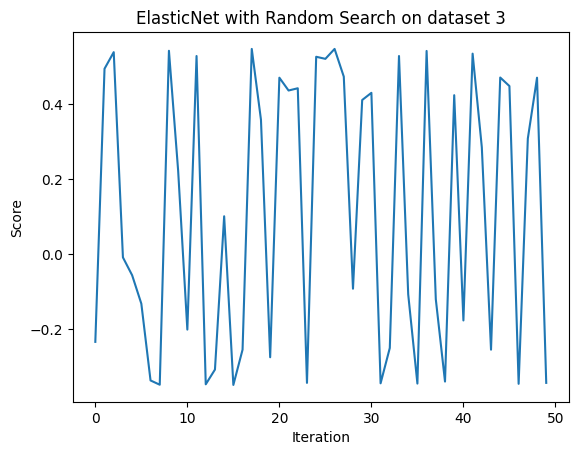

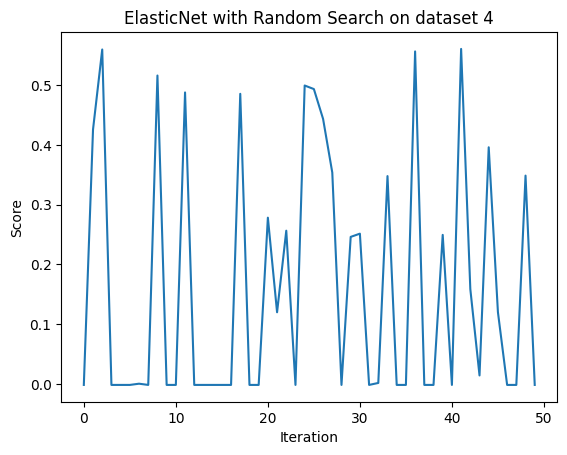

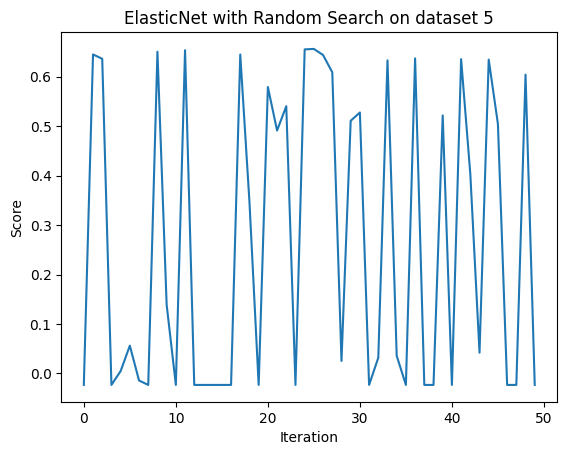

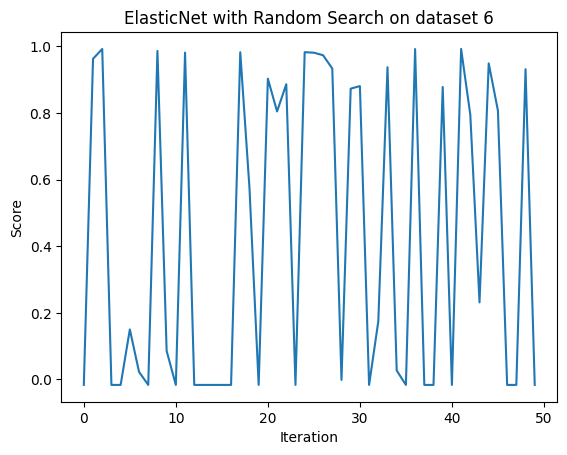

In [31]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"ElasticNet with Random Search on dataset {i}")
    plt.savefig(f"output_data/plots/random_search_elasticnet_{i}.png")
    plt.show()

## Calculate tunability on each dataset

In [32]:
# find d^j

tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_elasticnet_configs_for_each_dataset,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/random_search_tunability.csv",
)

d^j: 0.9497549084200523 - 0.9497549084200523 = 0.0
d^j: 0.9233088215231575 - 0.923922092472427 = -0.0006132709492694399
d^j: 0.45658166685444057 - 0.4647832830745732 = -0.008201616220132601
d^j: 0.543178121379066 - 0.5486076640143884 = -0.005429542635322471
d^j: 0.556445284954607 - 0.5606357787721593 = -0.004190493817552321
d^j: 0.6371515614536902 - 0.6562711803182308 = -0.01911961886454061
d^j: 0.9916804136395898 - 0.9921425833911399 = -0.0004621697515501122


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.239e+03, tolerance: 3.510e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


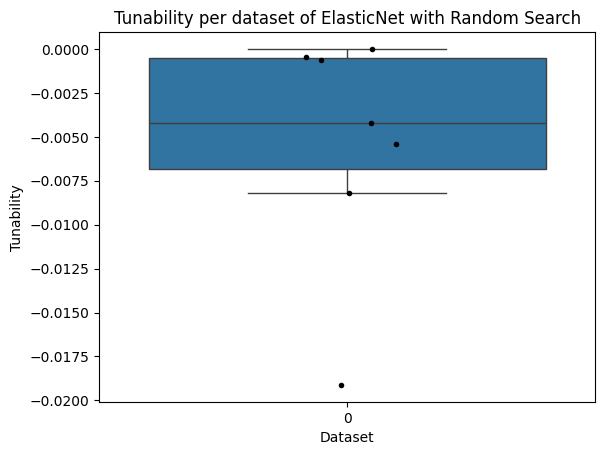

In [33]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of ElasticNet with Random Search")
plt.savefig("output_data/plots/tunability_RS_elasticnet.png")
# show the plot
plt.show()

In [34]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.005430958891195365


## Find best hyperparameters for given dataset with bayesian search


In [35]:
def get_bayes_search_space_elasticnet():
    return (
        {
            "model__alpha": Real(2 ** (-10), 2**10),
            "model__l1_ratio": Real(0.0, 1.0),
        },
        NUM_ITER_BAYES,
    )

In [36]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
best_configs_for_elasticnet, histories = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_elasticnet(),
    get_pipeline=get_elasticnet_pipeline,
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/elasticnet/bayes_iteration_scores_dataset_{i}.csv"
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.05300050671191929
Iteration 2: Score = -0.05320919309927983
Iteration 3: Score = -0.05320919309927983
Iteration 4: Score = -0.05320919309927983
Iteration 5: Score = -0.05320919309927983
Iteration 6: Score = -0.05320919309927983
Iteration 7: Score = -0.05320919309927983
Iteration 8: Score = -0.009068175531103794
Iteration 9: Score = -0.05320919309927983
Iteration 10: Score = -0.05320919309927983
Iteration 11: Score = 0.9101571674898745
Iteration 12: Score = 0.9101924584250278
Iteration 13: Score = -0.04617643895059702
Iteration 14: Score = 0.7523822910943555
Iteration 15: Score = 0.905113651019357
Iteration 16: Score = 0.9101571674898745
Iteration 17: Score = -0.05320919309927983
Iteration 18: Score = 0.9101571674898745
Iteration 19: Score = -0.05320919309927983
Iteration 20: Score = -0.05320919309927983
Iteration 21: Score = 0.9101571674898745
Iteration 22: Score = -0.05320919309927983
Iteration 23: Score = 0.9101571674898745
Iteration 24: Score = -0.05320919309

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.001437330612278198
Iteration 2: Score = -0.0010060662102646667
Iteration 3: Score = -0.0011925065389774224
Iteration 4: Score = -0.001094199023740039
Iteration 5: Score = -0.00011250044186874585
Iteration 6: Score = 0.14279243349992166
Iteration 7: Score = -0.0009703952830844243
Iteration 8: Score = 0.04209155102667024
Iteration 9: Score = -0.00022593336827763099
Iteration 10: Score = 0.0020792411769508857
Iteration 11: Score = 0.9047726098202171
Iteration 12: Score = 0.9048660222696572
Iteration 13: Score = 0.9048563306610411
Iteration 14: Score = 0.6594185020188883
Iteration 15: Score = 0.9048563306610411
Iteration 16: Score = 0.904868783005424
Iteration 17: Score = -0.00125758705320822
Iteration 18: Score = 0.9048563306610411
Iteration 19: Score = 0.904867097214809
Iteration 20: Score = 0.36684358494143987
Iteration 21: Score = 0.9047328017324453
Iteration 22: Score = 0.9048722254539072
Iteration 23: Score = 0.9048763501625192
Iteration 24: Score = 0.90348633

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.030468644138217815
Iteration 2: Score = -0.030468644138217815
Iteration 3: Score = -0.030468644138217815
Iteration 4: Score = -0.030468644138217815
Iteration 5: Score = -0.030468644138217815
Iteration 6: Score = -0.030468644138217815
Iteration 7: Score = -0.030468644138217815
Iteration 8: Score = -0.02991555950378122
Iteration 9: Score = -0.030468644138217815
Iteration 10: Score = -0.030468644138217815
Iteration 11: Score = -0.030468644138217815
Iteration 12: Score = 0.45343038779106803
Iteration 13: Score = -0.02947928992228186
Iteration 14: Score = 0.4532927557342692
Iteration 15: Score = 0.013072130979467623
Iteration 16: Score = 0.4533566439031981
Iteration 17: Score = -0.025412003229298576
Iteration 18: Score = 0.4533628656627651
Iteration 19: Score = 0.024015086399863272
Iteration 20: Score = 0.45223056785996596
Iteration 21: Score = -0.030468644138217815
Iteration 22: Score = 0.4493817031984519
Iteration 23: Score = 0.4493817031984519
Iteration 24: Score 

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.08546393921951445
Iteration 2: Score = -0.08500262562989036
Iteration 3: Score = -0.0848889901612638
Iteration 4: Score = -0.08469386676301105
Iteration 5: Score = -0.084262284179152
Iteration 6: Score = 0.02710591299015521
Iteration 7: Score = -0.08437985311017104
Iteration 8: Score = -0.05462486118735714
Iteration 9: Score = -0.08440626232101314
Iteration 10: Score = -0.0827949926939017
Iteration 11: Score = 0.49278989227980025
Iteration 12: Score = 0.5453048281365958
Iteration 13: Score = 0.5476491160902036
Iteration 14: Score = 0.10622262590904744
Iteration 15: Score = 0.5810190937386308
Iteration 16: Score = 0.3735276028857057
Iteration 17: Score = 0.5656360777792899
Iteration 18: Score = 0.5798864575370019
Iteration 19: Score = -0.0848200361896545
Iteration 20: Score = -0.08354888749746867
Iteration 21: Score = -0.08310333376023885
Iteration 22: Score = -0.08512720454635576
Iteration 23: Score = 0.49278989227980025
Iteration 24: Score = 0.5466918090808535


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.007952659633162319
Iteration 2: Score = -0.007952659633162319
Iteration 3: Score = -0.007952659633162319
Iteration 4: Score = -0.007952659633162319
Iteration 5: Score = -0.007952659633162319
Iteration 6: Score = -0.007952659633162319
Iteration 7: Score = -0.007952659633162319
Iteration 8: Score = -0.007952659633162319
Iteration 9: Score = -0.007952659633162319
Iteration 10: Score = -0.007952659633162319
Iteration 11: Score = 0.08689546530368483
Iteration 12: Score = 0.7121229943426186
Iteration 13: Score = 0.178335376311425
Iteration 14: Score = -0.007659361539692933
Iteration 15: Score = 0.7121229943426186
Iteration 16: Score = -0.006212678975104158
Iteration 17: Score = 0.7121229943426186
Iteration 18: Score = 0.0007324442480687754
Iteration 19: Score = 0.7121229943426186
Iteration 20: Score = -0.007952659633162319
Iteration 21: Score = 0.7121229943426186
Iteration 22: Score = 0.712036217154554
Iteration 23: Score = 0.04991064343202649
Iteration 24: Score = -0

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = -0.0028718766188328805
Iteration 2: Score = -0.0028718766188328805
Iteration 3: Score = -0.0028718766188328805
Iteration 4: Score = -0.0028718766188328805
Iteration 5: Score = -0.0028718766188328805
Iteration 6: Score = -0.0028718766188328805
Iteration 7: Score = -0.0028718766188328805
Iteration 8: Score = -0.0028718766188328805
Iteration 9: Score = -0.0028718766188328805
Iteration 10: Score = -0.0028718766188328805
Iteration 11: Score = 0.3922595605583819
Iteration 12: Score = 0.9939682059870357
Iteration 13: Score = 0.9941345813131985
Iteration 14: Score = 0.9941573468715752
Iteration 15: Score = 0.9941498737006664
Iteration 16: Score = 0.9941792390776578
Iteration 17: Score = -0.0028718766188328805
Iteration 18: Score = 0.9942086481989879
Iteration 19: Score = -0.0028718766188328805
Iteration 20: Score = 0.9941613073658371
Iteration 21: Score = -0.0028718766188328805
Iteration 22: Score = -0.0028718766188328805
Iteration 23: Score = -0.0028718766188328805
Iterat

### Plot bayes optimization history for each dataset

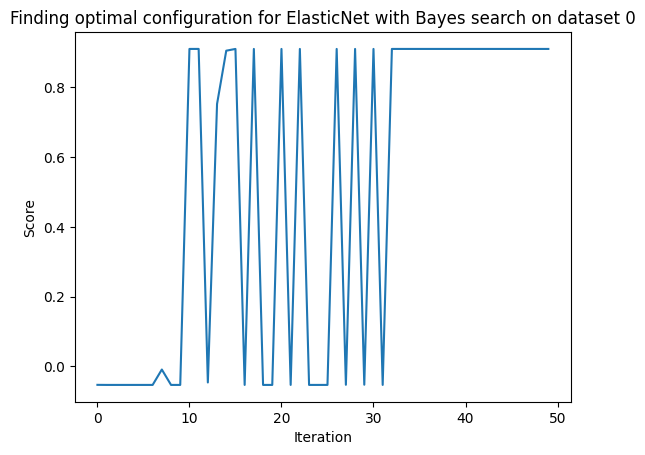

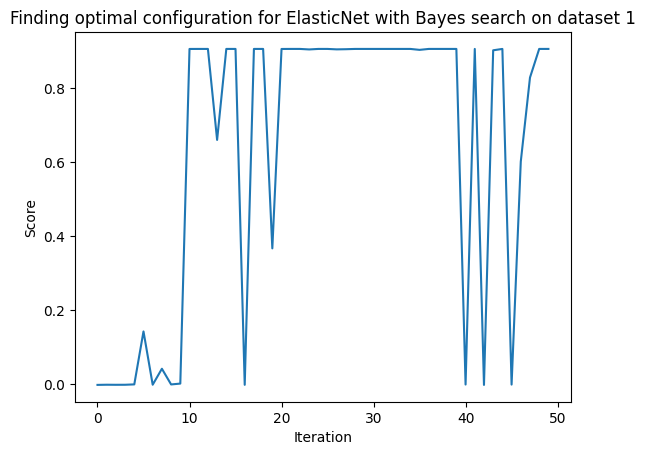

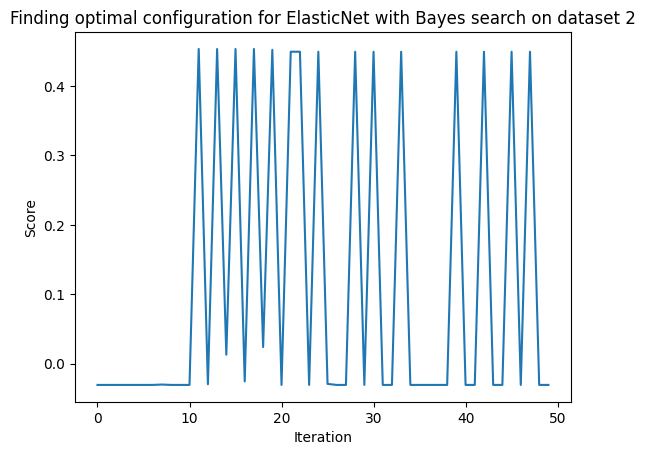

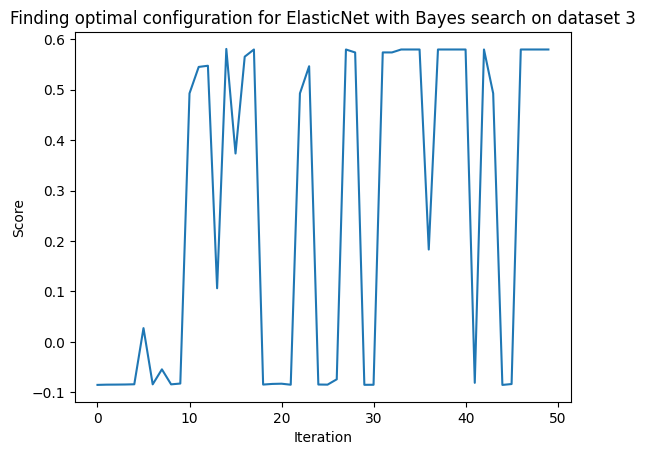

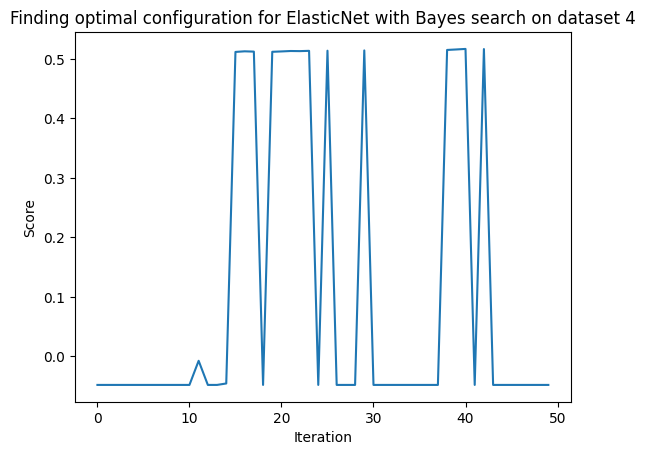

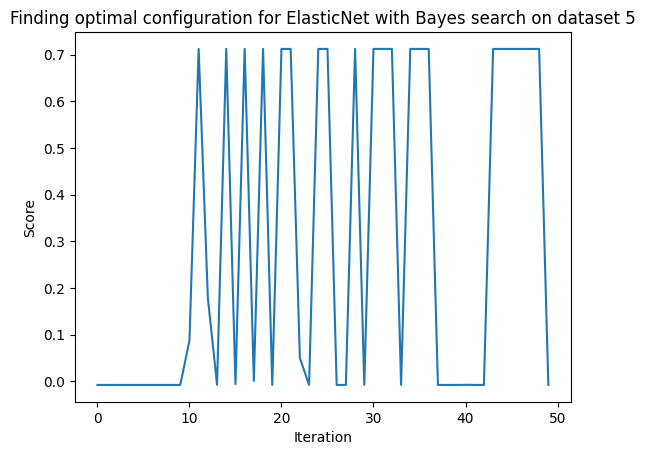

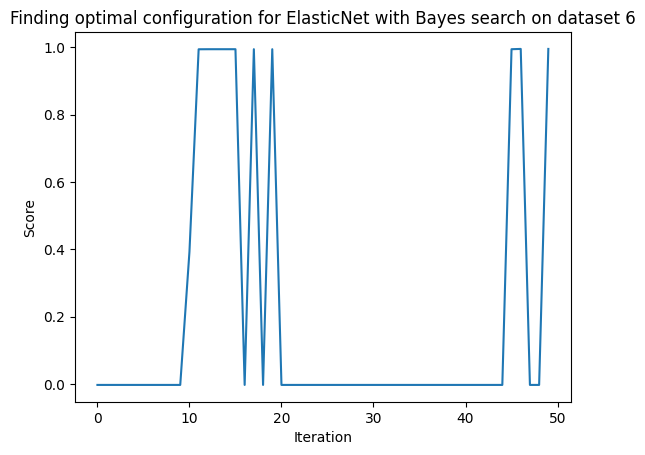

In [37]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for ElasticNet with Bayes search on dataset {i}"
    )
    plt.savefig(f"output_data/plots/bayes_elasticnet_{i}.png")
    plt.show()

## Calculate tunability on each dataset

In [38]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_elasticnet,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/bayes_tunability.csv",
)

d^j: 0.9497549084200523 - 0.9500978080582081 = -0.0003428996381558136
d^j: 0.9233088215231575 - 0.9232982198727927 = 1.0601650364816528e-05


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.182e+05, tolerance: 2.145e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


d^j: 0.45658166685444057 - 0.4568785360227773 = -0.00029686916833671084
d^j: 0.543178121379066 - 0.4228567505795937 = 0.12032137079947225
d^j: 0.556445284954607 - 0.5633214415369787 = -0.0068761565823717286
d^j: 0.6371515614536902 - 0.6382684740785797 = -0.0011169126248894434
d^j: 0.9916804136395898 - 0.9928203996602365 = -0.0011399860206466883


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.883e+03, tolerance: 3.510e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


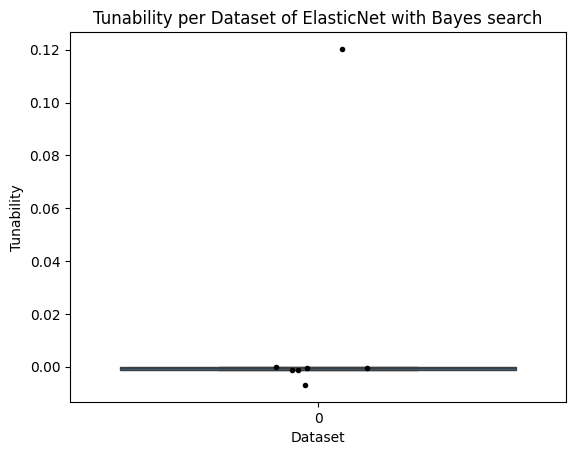

In [39]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of ElasticNet with Bayes search")
plt.savefig("output_data/plots/tunability_BO_elasticnet.png")
# show the plot
plt.show()

In [40]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.0157941640593481


# 3. Random Forest

## Prepare model and search space

In [41]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor(bootstrap=True, random_state=SEED)
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [42]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(SEED)
    # max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 528, 5)
    min_samples_leaf_values = range(1, 10, 1)
    n_estimators_values = range(1, 2000, 10)
    max_samples_values = [float(i) * 0.1 for i in range(1, 11, 1)]
    max_features_values = [i for i in range(1, 15, 1)]
    all_combinations = list(
        itertools.product(
            # max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
            max_samples_values,
            max_features_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_RANDOM_FOREST
    )
    parameter_names = [
        # "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
        "model__max_samples",
        "model__max_features",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

## Find optimal default hyperparameters 

In [43]:
(
    optimal_config_random_forest,
    best_summary_score_random_forest,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_for_random_forest(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    get_model=get_random_forest_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/random_forest/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


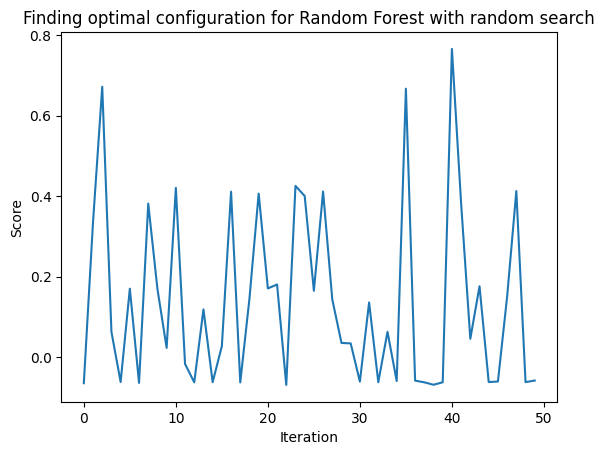

In [44]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Random Forest with random search")
plt.savefig("output_data/plots/optimal_random_forest.png")
plt.show()

In [45]:
print(optimal_config_random_forest)
print(best_summary_score_random_forest)

{'model__min_samples_split': 12, 'model__min_samples_leaf': 2, 'model__n_estimators': 1701, 'model__max_samples': 0.30000000000000004, 'model__max_features': 10}
0.7659941446301094


## Evaluate model with optimal hyperparameters on each dataset

In [46]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_random_forest_pipeline()
    optimal_model.set_params(**optimal_config_random_forest)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal random_forest score on dataset : " + str(score))

Optimal random_forest score on dataset : 0.9282166132771148
Optimal random_forest score on dataset : 0.9176466389134765
Optimal random_forest score on dataset : 0.49198395355568325
Optimal random_forest score on dataset : 0.642992789356442
Optimal random_forest score on dataset : 0.5858888081475064
Optimal random_forest score on dataset : 0.8070435497635913
Optimal random_forest score on dataset : 0.9881866593969507


## Find best hyperparameters for given dataset with random search

In [47]:
# find tate^(j)*
(
    best_random_forest_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    get_pipeline=get_random_forest_pipeline,
    config_space=get_parameter_grid_for_random_forest(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/random_forest/random_search_iteration_scores_dataset_{i}.csv",
    )

dataset: 0
score: 0.9282166132771148
best config: {'model__min_samples_split': 12, 'model__min_samples_leaf': 2, 'model__n_estimators': 1701, 'model__max_samples': 0.30000000000000004, 'model__max_features': 10}
dataset: 1
score: 0.9176466389134765
best config: {'model__min_samples_split': 12, 'model__min_samples_leaf': 2, 'model__n_estimators': 1701, 'model__max_samples': 0.30000000000000004, 'model__max_features': 10}
dataset: 2
score: 0.49198395355568325
best config: {'model__min_samples_split': 12, 'model__min_samples_leaf': 2, 'model__n_estimators': 1701, 'model__max_samples': 0.30000000000000004, 'model__max_features': 10}
dataset: 3
score: 0.642992789356442
best config: {'model__min_samples_split': 12, 'model__min_samples_leaf': 2, 'model__n_estimators': 1701, 'model__max_samples': 0.30000000000000004, 'model__max_features': 10}
dataset: 4
score: 0.5858888081475064
best config: {'model__min_samples_split': 12, 'model__min_samples_leaf': 2, 'model__n_estimators': 1701, 'model__ma

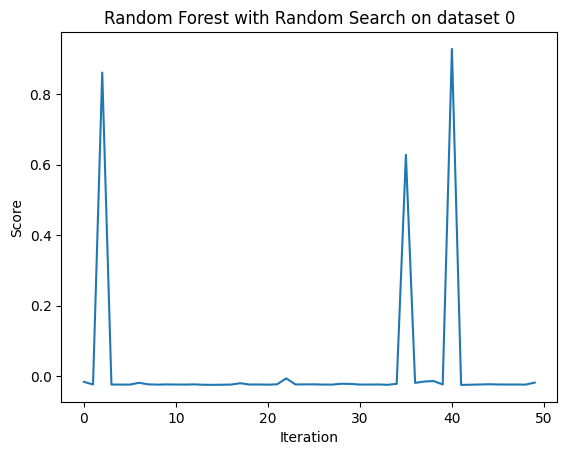

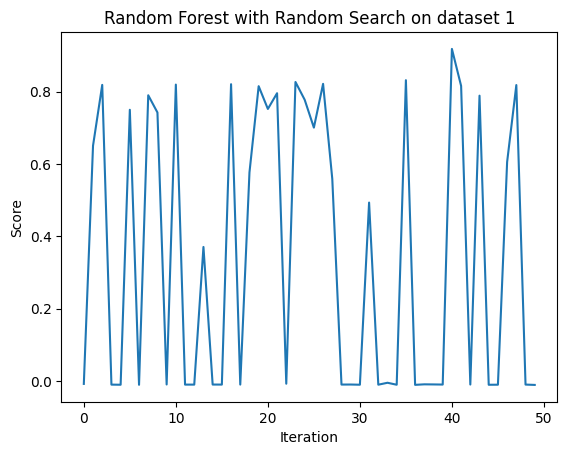

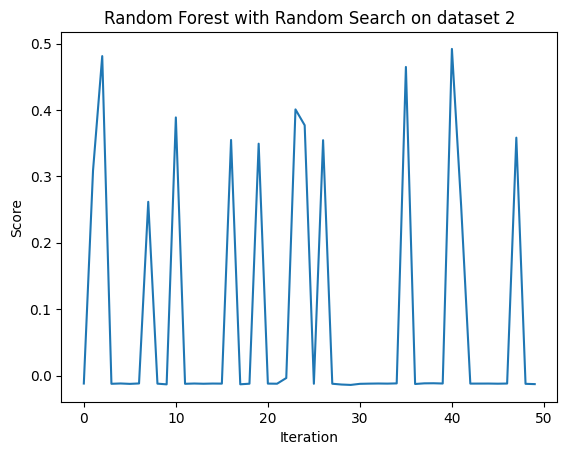

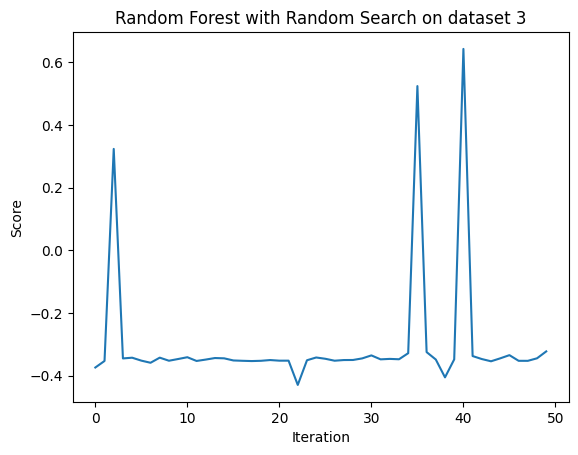

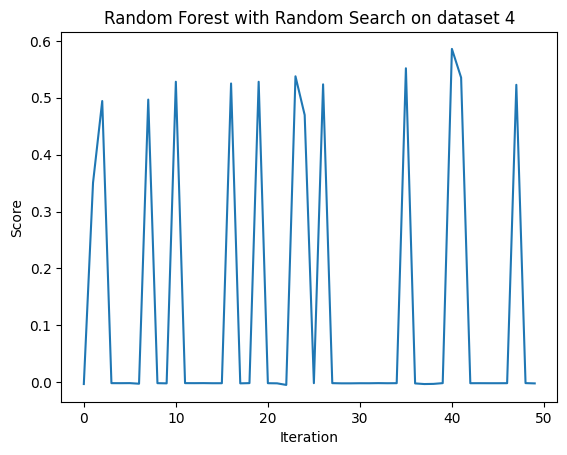

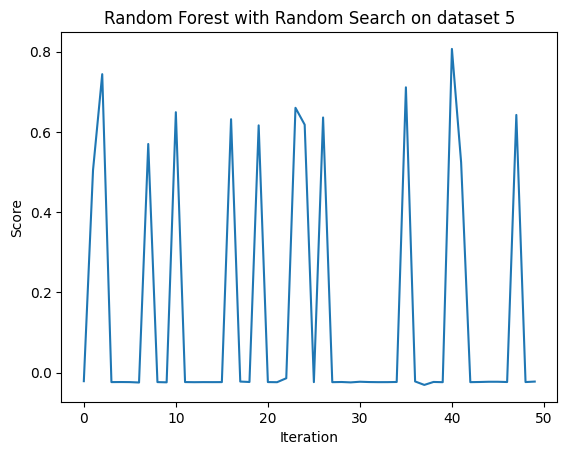

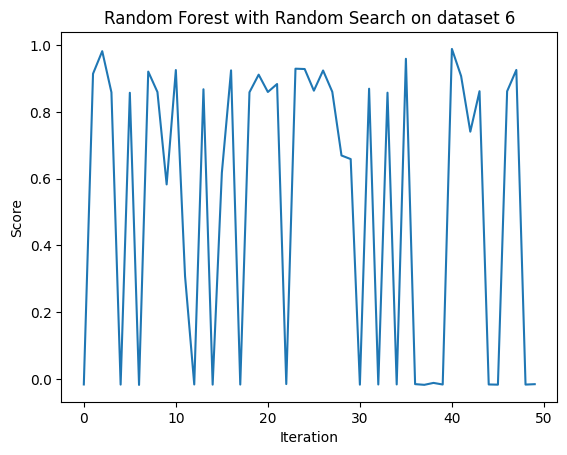

In [48]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Random Forest with Random Search on dataset {i}")
    plt.savefig(f"output_data/plots/random_search_random_forest_{i}.png")
    plt.show()

## Calculate tunability on each dataset

In [49]:
# find d^j

tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_random_forest_configs_for_each_dataset,
    optimal_config=optimal_config_random_forest,
    get_model_pipeline=get_random_forest_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/random_forest/random_search_tunability.csv",
)

d^j: 0.9282166132771148 - 0.9282166132771148 = 0.0
d^j: 0.9176466389134765 - 0.9176466389134765 = 0.0
d^j: 0.49198395355568325 - 0.49198395355568325 = 0.0
d^j: 0.642992789356442 - 0.642992789356442 = 0.0
d^j: 0.5858888081475064 - 0.5858888081475064 = 0.0
d^j: 0.8070435497635913 - 0.8070435497635913 = 0.0
d^j: 0.9881866593969507 - 0.9881866593969507 = 0.0


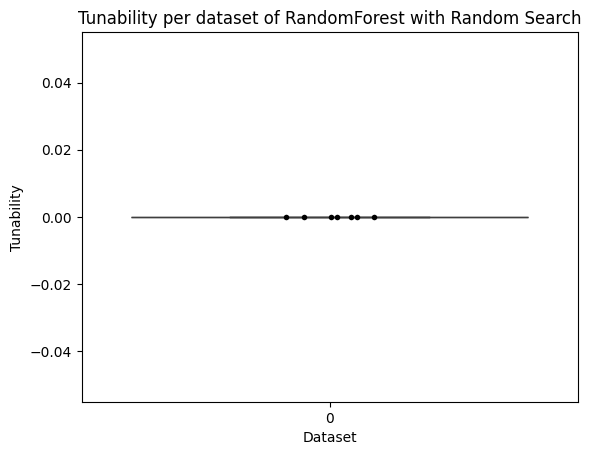

In [50]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of RandomForest with Random Search")
plt.savefig("output_data/plots/tunability_RS_random_forest.png")

# show the plot
plt.show()

In [51]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.0


## Find best hyperparameters for given dataset with bayesian search


In [52]:
def get_bayes_search_space_random_forest():
    return (
        {
            "model__min_samples_split": Integer(2, 528),
            "model__min_samples_leaf": Integer(2, 10),
            "model__min_samples_leaf": Integer(1, 60),
            "model__n_estimators": Integer(1, 2000),
            "model__max_samples": Real(0.1, 1.0),
            "model__max_features": Integer(1, 14),
        },
        NUM_ITER_BAYES,
    )

In [53]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
(
    best_configs_for_random_forest,
    histories,
) = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_random_forest(),
    get_pipeline=get_random_forest_pipeline,
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/random_forest/bayes_iteration_scores_dataset_{i}.csv"
    )

Iteration 1: Score = -0.05500780196223154
Iteration 2: Score = -0.05335461458060235
Iteration 3: Score = -0.05290584127827662
Iteration 4: Score = -0.05347222446679689
Iteration 5: Score = -0.053352325026073545
Iteration 6: Score = -0.052941045562013844
Iteration 7: Score = -0.05332856702013302
Iteration 8: Score = -0.0542752421435563
Iteration 9: Score = 0.7856232630581254
Iteration 10: Score = 0.18860142006056768
Iteration 11: Score = 0.8124323717430071
Iteration 12: Score = -0.053110034812621755
Iteration 13: Score = 0.8870159731341017
Iteration 14: Score = -0.053110034812621755
Iteration 15: Score = 0.890421894989762
Iteration 16: Score = 0.8413958315696032
Iteration 17: Score = 0.8592812579273433
Iteration 18: Score = 0.7048250848249243
Iteration 19: Score = 0.8894211909639326
Iteration 20: Score = 0.8998075485869146
Iteration 21: Score = 0.8905567901731034
Iteration 22: Score = 0.2566254342767178
Iteration 23: Score = 0.860350439294854
Iteration 24: Score = 0.9013450778534416
Ite

### Plot bayes optimization history for each dataset

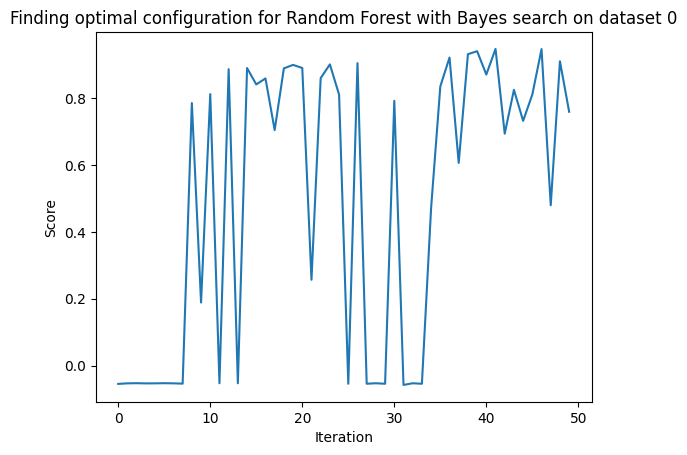

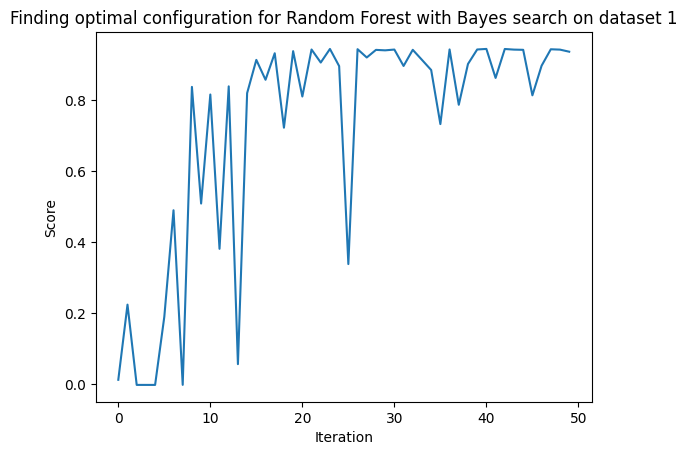

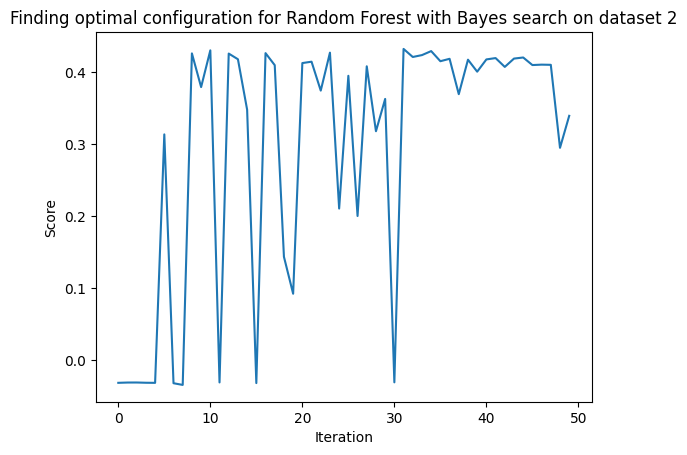

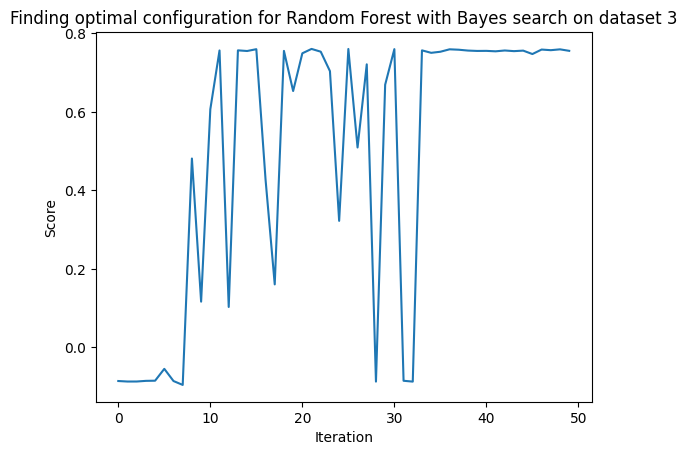

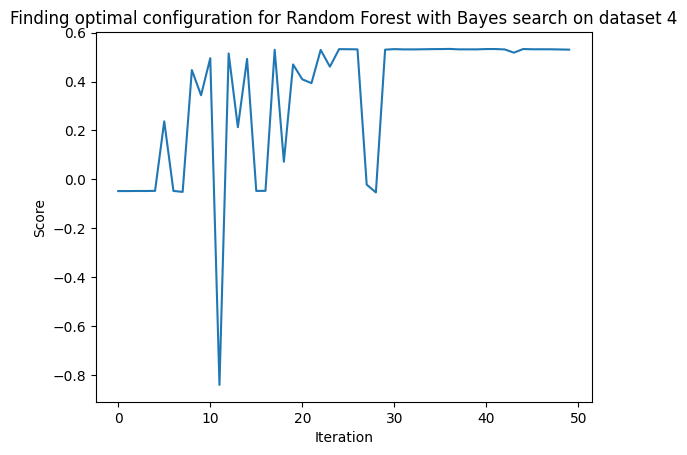

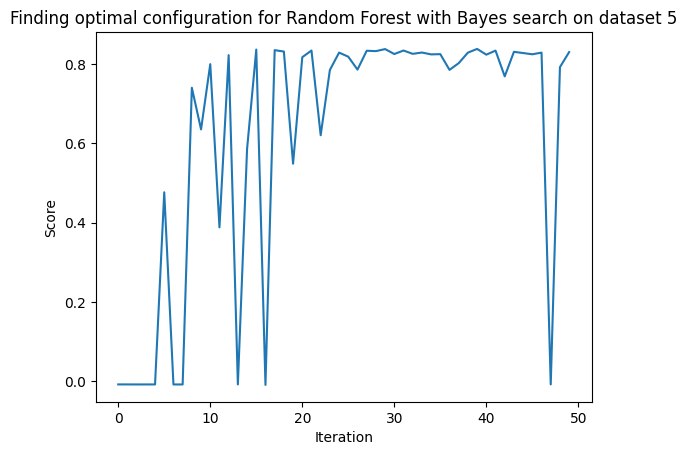

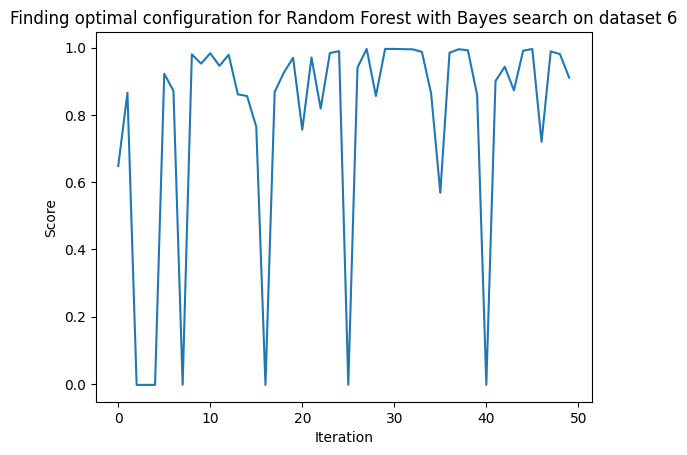

In [54]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for Random Forest with Bayes search on dataset {i}"
    )
    plt.savefig(f"output_data/plots/bayes_random_forest_{i}.png")
    plt.show()

## Calculate tunability on each dataset

In [55]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_random_forest,
    optimal_config=optimal_config_random_forest,
    get_model_pipeline=get_random_forest_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/random_forest/bayes_tunability.csv",
)

d^j: 0.9282166132771148 - 0.9698124996665838 = -0.04159588638946898
d^j: 0.9176466389134765 - 0.9597568722594442 = -0.04211023334596764
d^j: 0.49198395355568325 - 0.4839573148373505 = 0.008026638718332757
d^j: 0.642992789356442 - 0.680170205130087 = -0.03717741577364497
d^j: 0.5858888081475064 - 0.6004298775952965 = -0.0145410694477901
d^j: 0.8070435497635913 - 0.8722055515373888 = -0.0651620017737975
d^j: 0.9881866593969507 - 0.9920866457748558 = -0.003899986377905118


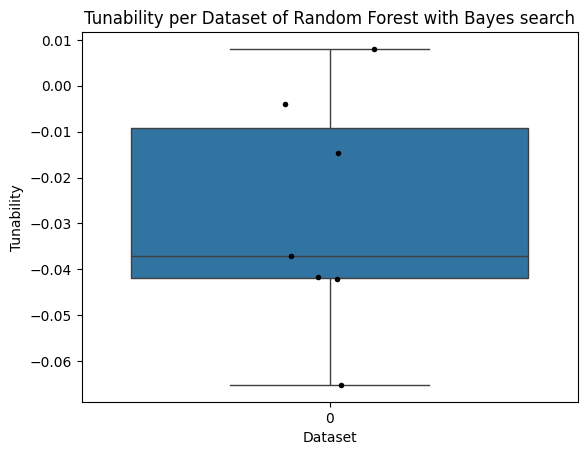

In [56]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

sns.stripplot(data=tunability_data, color="black", size=4)

plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Random Forest with Bayes search")
plt.savefig("output_data/plots/tunability_BO_random_forest.png")

plt.show()

In [57]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.028065707770034507
